# Banking Marketing -  Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



Imports:

In [95]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer

from sklearn.metrics import RocCurveDisplay, roc_curve, auc,roc_auc_score, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report

### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portuguese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y). The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date, very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

**For this specific project the bank-additional-full.csv dataset will be used**.

Additional information:

According to the provided paper, the dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored and if there was a success (the target variable). For the whole database considered in the paper, there were 6499 successes (8% success rate). 

Note: The success rate in the dataset used is slightly different. To check the success rate of the campaign go to Problem 2.



### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Failure and Success rate of the campaign**

The code below calculates the failure rate of the marketing campaign. It does so by first selecting only the 'y' column using df[['y']], it then applies a boolean query filter only keeping those rows where 'y' is 'no' (query("y=='no'")), and finally, it counts these rows using count(). The number of rows where 'y' is 'no' (the number of 'failures') is divided by the total number of rows in the 'y' column to get the failure rate. In a similar logic the success rate is calculated.

In [4]:
failure_rate = df[['y']].query("y=='no'").count() / df['y'].count()

success_rate = (df[['y']].query("y=='yes'").count() / df['y'].count())

print('The failure rate of the marketing campaign is: '+str(round(failure_rate.iloc[0],3)*100)+'%' )
print('The success rate of the marketing campaign is: '+str(round(success_rate.iloc[0],3)*100)+'%' )

The failure rate of the marketing campaign is: 88.7%
The success rate of the marketing campaign is: 11.3%


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.

```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')


# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)



Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



**According to the above data description**:

- **Numeric Variables**: 'age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', and 'nr.employed' are described as numeric. Before proceeding, I should confirm if they are correctly stored as integers or floats. If I find any anomalies (like numeric values stored as strings), coercion to the correct datatype will be required.

- **Categorical Variables**: Variables like 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', and 'poutcome' are described as categorical. Is should ensure these are appropriately categorized, and consider encoding them using techniques like one-hot encoding or ordinal encoding, based on my analysis or modelling requirements.

- **(Optional) Unknown Values**: I noticed that for some categorical variables like 'job', 'marital', 'education', 'default', 'housing', and 'loan' there is an 'unknown' category. Depending on the context and the analysis requirement, these 'unknown' categories might be treated as missing values.

- **Special Notes**: The 'duration' variable should be dropped - the description suggests avoiding usage of this variable if the intention is to create a predictive model.

- **Output Variable**: The output variable 'y' is binary and may need to be encoded to 0 and 1 if the modeling technique I plan to use requires numerical input.

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

According to the results below, there are no missing values in any of the features.

In [6]:
print('Missing values per feature:')
print(df.isna().sum())

Missing values per feature:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [7]:
print('Total Missing values:')
print(df.isna().sum().sum() )

Total Missing values:
0


Numeric features of type int:

In [8]:
print('Numeric Features of type int64:')
int64_feat = df.select_dtypes(include='int64').columns.tolist()
print(int64_feat )

df[int64_feat].head(5)

Numeric Features of type int64:
['age', 'duration', 'campaign', 'pdays', 'previous']


,age,duration,campaign,pdays,previous
0,56,261,1,999,0
1,57,149,1,999,0
2,37,226,1,999,0
3,40,151,1,999,0
4,56,307,1,999,0


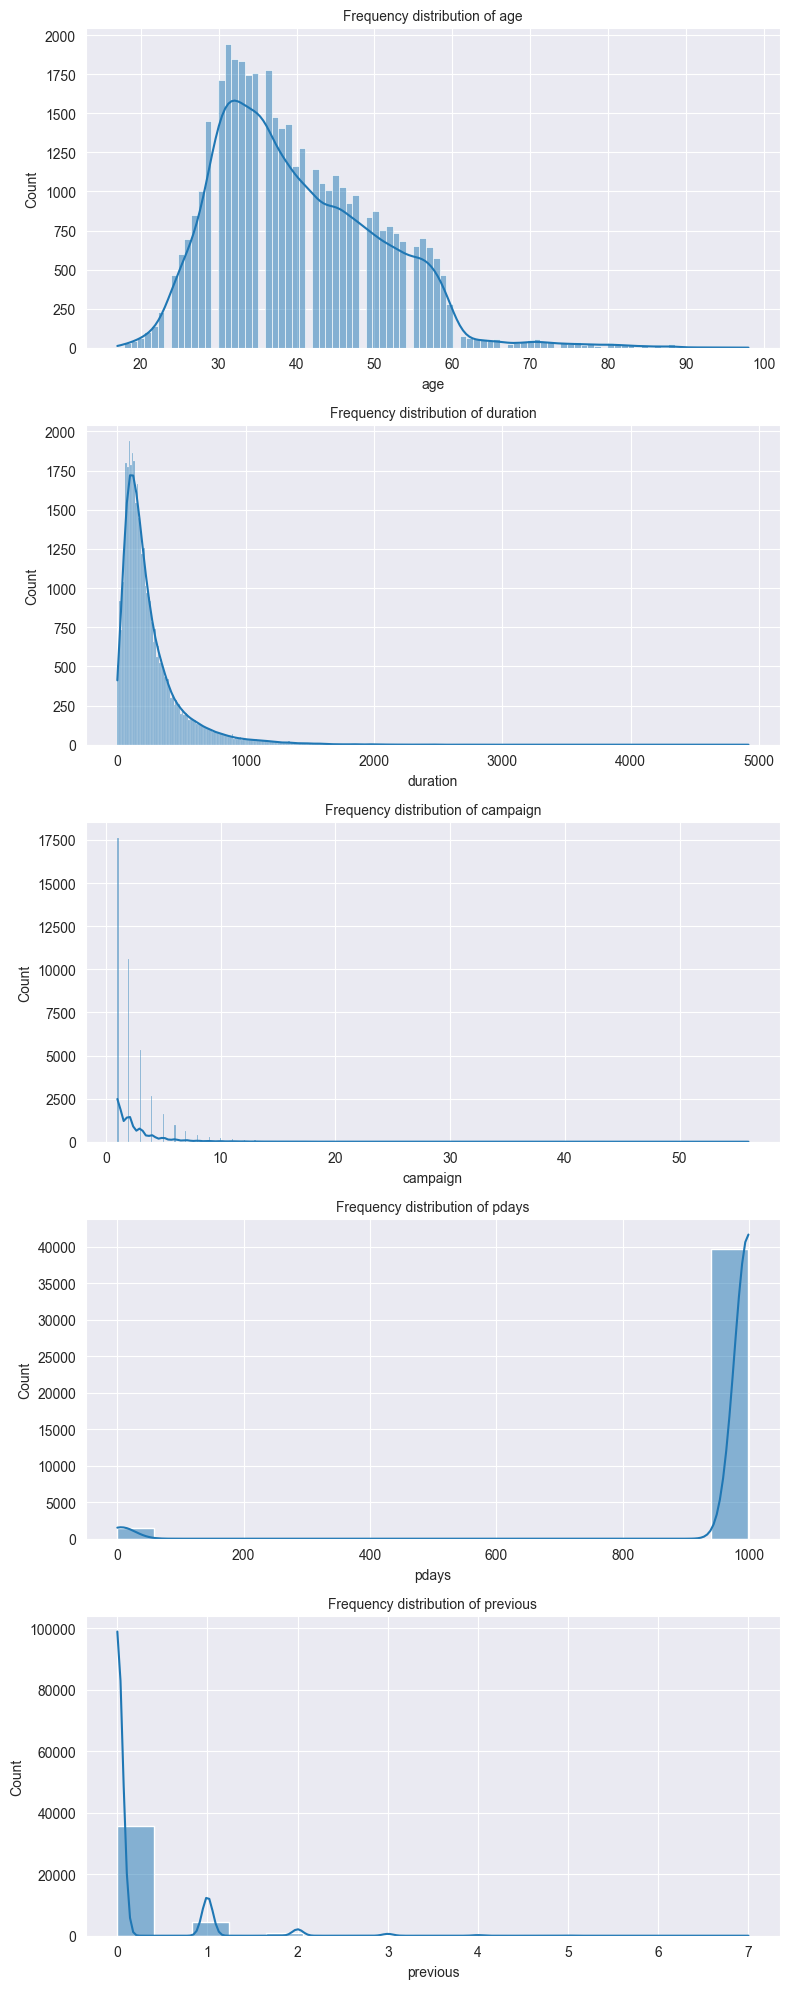

In [9]:
# numeric features of type int64
# plotting their distributions:
fig, axs = plt.subplots(len(int64_feat), figsize=(8, 4*len(int64_feat)))  # Adjust the size as necessary

for i, col_val in enumerate(int64_feat):
    sns.histplot(df[col_val], kde=True, ax=axs[i])
    axs[i].set_title('Frequency distribution of ' + str(col_val), fontsize=10)

plt.tight_layout()
plt.show()

The pdays feature represents the number of days that passed by after the client was last contacted from a previous campaign. It's a numeric feature, but the value 999 is used to indicate that the client hasn't been previously contacted. 

There are many ways to address this feature:
- Binary Transformation: Given that a large proportion of the pdays values might be 999, I can create a binary feature that indicates whether the customer had been previously contacted or not. Here, I can turn pdays into a binary feature where 'yes' indicates that the customer was contacted before, and 'no' indicates that they weren't.
- Missing Value Imputation: I can treat 999 values as missing values or NaN. After replacing 999 with NaN, pdays will only contain the actual number of days that passed for previously contacted customers. I can then decide how to handle these missing values depending on the context or the ML model I will use. Some models can handle NaN values inherently.
- Bucketing: I could retain the numeric nature of the variable but group the '999' values into a separate bucket. Bucketing or Binning can alleviate the effects of noisy data and help improve model robustness and performance. I might categorize '1-30', '31-60', '61-90', 'Over 90', 'Not Contacted', etc.

I should decide how to transform it by checking the frequency of every value:

In [10]:
#### grouping different values and applying the counting aggregator:
df[['pdays']].groupby('pdays').size()

pdays
0         15
1         26
2         61
3        439
4        118
5         46
6        412
7         60
8         18
9         64
10        52
11        28
12        58
13        36
14        20
15        24
16        11
17         8
18         7
19         3
20         1
21         2
22         3
25         1
26         1
27         1
999    39673
dtype: int64

According to the above analysis I could binarise the pdays feature. In other words I will create the feature contracted_before to use it in my modelling phase:

In [11]:
df['contacted_before'] = np.where(df['pdays'] != 999, 'yes', 'no')
df['contacted_before'].unique()

# dropping the feature:
df.drop(['pdays'],axis = "columns",inplace=True)


Note: Business wise, the 'previous' feature is closely connected in logic with the newly created 'contacted_before' feature.

In [12]:
#### grouping different values and applying the counting aggregator:
df[['previous']].groupby('previous').size()

previous
0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
dtype: int64

The above numeric features of type int64 will be standardised during the feature engineering phase. Now I should check the numeric features of type float64:

In [13]:
print('Numeric Features of type float64:')
float64_feat = df.select_dtypes(include='float64').columns.tolist()
print(float64_feat )

df[float64_feat].head(5)

Numeric Features of type float64:
['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.1,93.994,-36.4,4.857,5191.0
1,1.1,93.994,-36.4,4.857,5191.0
2,1.1,93.994,-36.4,4.857,5191.0
3,1.1,93.994,-36.4,4.857,5191.0
4,1.1,93.994,-36.4,4.857,5191.0


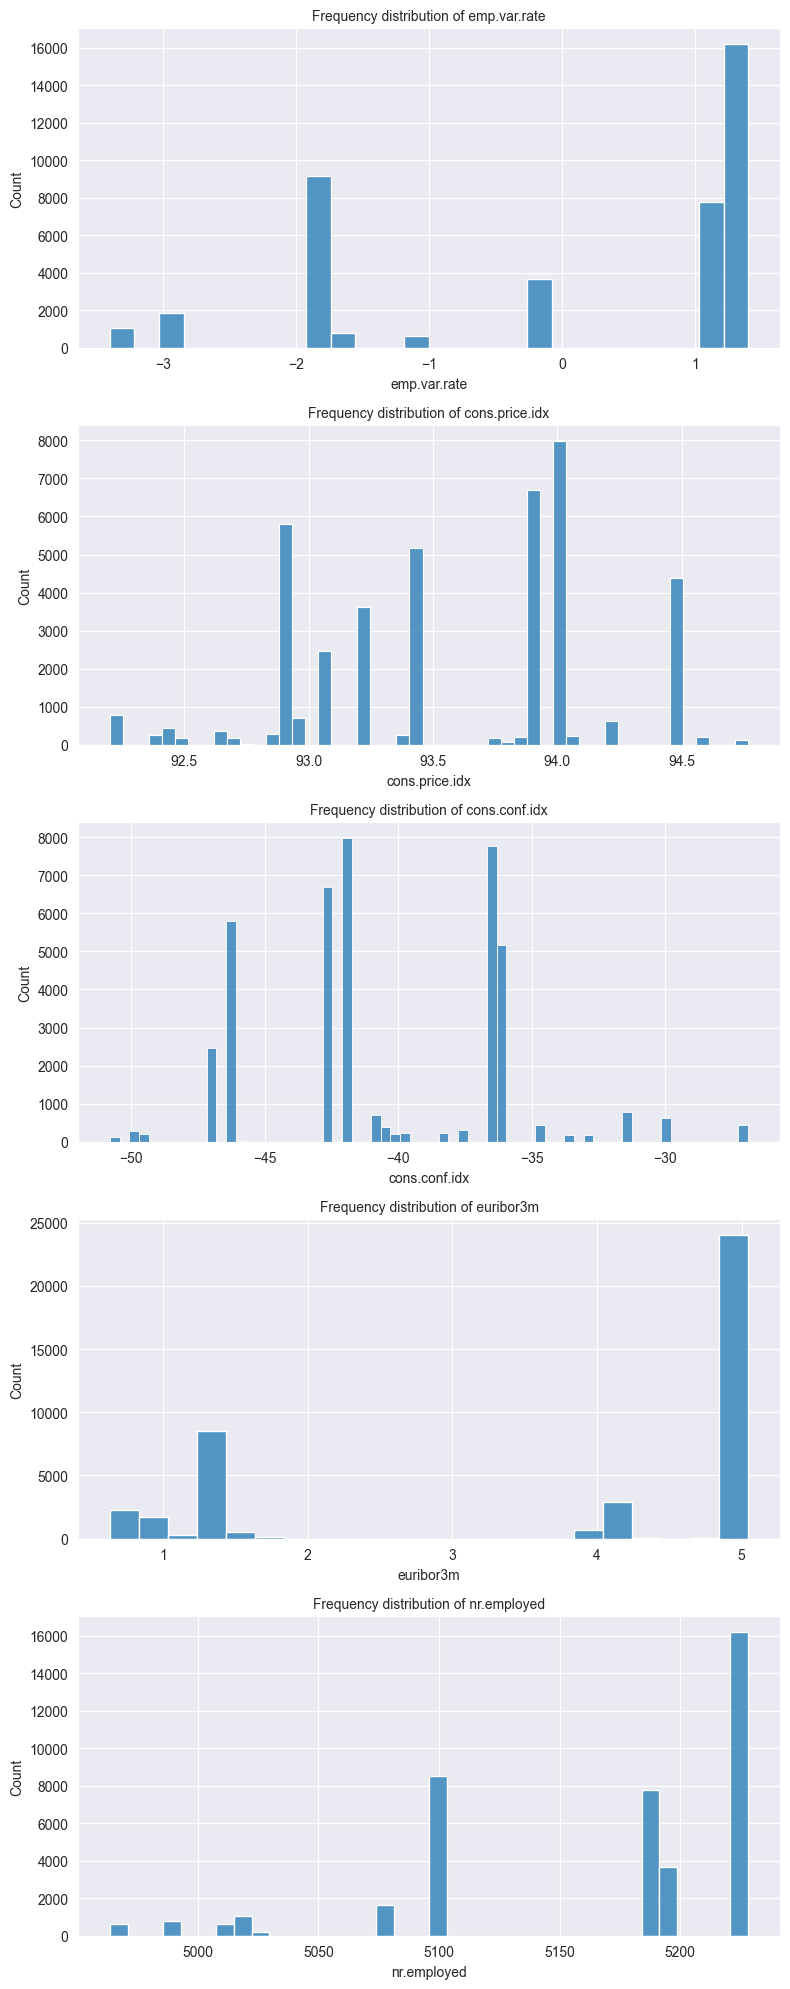

In [14]:
# numeric features of type int64
# plotting their distributions:
fig, axs = plt.subplots(len(float64_feat), figsize=(8, 4*len(float64_feat)))  # Adjust the size as necessary

for i, col_val in enumerate(float64_feat):
    sns.histplot(df[col_val], kde=False, ax=axs[i])
    axs[i].set_title('Frequency distribution of ' + str(col_val), fontsize=10)

plt.tight_layout()
plt.show()

The above numeric float variables are indexes. The above variables will be standardised during the feature engineering phase. Now let's have a look to the descriptive statistics of numeric features:

In [15]:
df.describe()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Now I should examine the categorical features:

In [16]:
print('Categorical Features (type is object):')
#select all the categorical features:
cat_feat = df.select_dtypes(include='object').columns.tolist()
#do not include target variable 'y':
cat_feat = [feat for feat in cat_feat if feat != 'y']
print(cat_feat )

df[cat_feat].head(5)

Categorical Features (type is object):
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'contacted_before']


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,contacted_before
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no


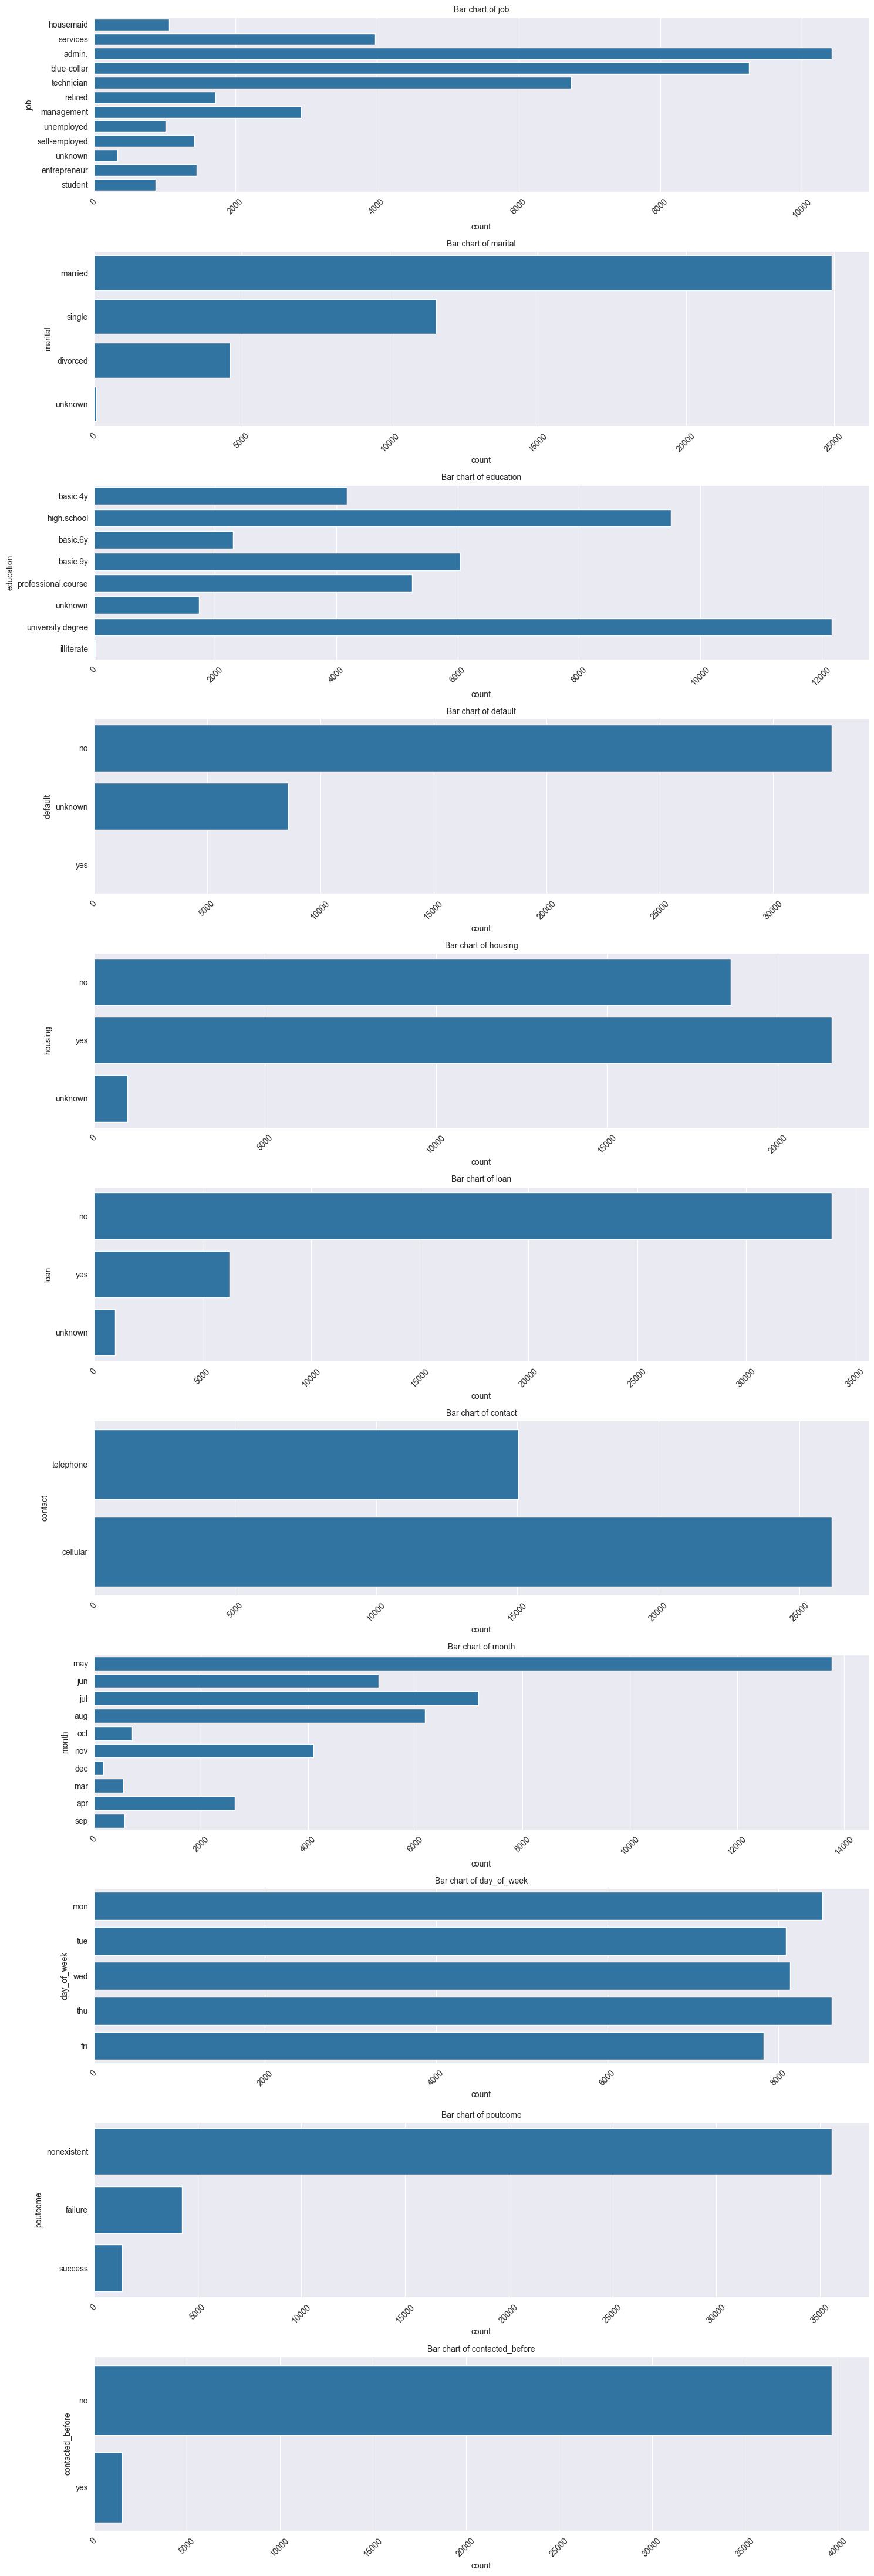

In [17]:
fig, axs = plt.subplots(len(cat_feat), figsize=(15, 4*len(cat_feat)))  # Adjust the size as necessary

# This code loops through your categorical features 
# and creates a bar chart for each on a separate subplot. 
for i, col_val in enumerate(cat_feat):
    sns.countplot(df[col_val], ax=axs[i])
    axs[i].set_title('Bar chart of ' + str(col_val), fontsize=10)
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)  # Rotates X-axis labels for readability

plt.tight_layout()
plt.show()

In the above plots I noticed that many features contain the 'unknown' value. Also for most of the features the percentage of 'unknown' values is relatively small, so I might consider imputing these with the most common category (mode), or using a more sophisticated method to guess the missing value such as k-Nearest Neighbors or Multivariate Imputation by Chained Equations (MICE). An exception is the 'default' feature where the proportion of 'unknown' values is bigger than the proportion of the 'yes' values.

In [18]:
unknown_val_feats = []
for col in cat_feat:
    if 'unknown' in df[col].unique():
        print(col)
        unknown_val_feats.append(col)

unknown_val_feats

job
marital
education
default
housing
loan


['job', 'marital', 'education', 'default', 'housing', 'loan']

I will apply the KNNimputer() for the above categorical variables.To apply KNNImputer of sklearn to categorical variables, I need to transform the categorical variables into numerical format first. Also, I will create the dictionary les to store LabelEncoder instances for each categorical column, to inverse-transform the data after imputation. After performing KNN imputation, I inverse-transform the data back to original categorical form using stored LabelEncoder instances. 

In [19]:
# Subset the dataframe to only columns in unknown_val_feats
df_subset = df[unknown_val_feats]

# Make a copy of the subset
df_filled = df_subset.copy()
df_filled.replace('unknown', np.nan, inplace=True)
# We will store the label encoders for each variable in a dictionary 
# so we can convert back after imputation
les = {}

# Loop over each column of the DataFrame
for col in df_filled.columns:
    le = LabelEncoder()
    df_filled[col] = le.fit_transform(df_filled[col])
    les[col] = le  # storing the LabelEncoder instance for later use

# Perform KNN imputation
imputer = KNNImputer(n_neighbors=3)
df_filled = imputer.fit_transform(df_filled)

# Convert the imputed data back to categorical
df_filled = pd.DataFrame(df_filled, columns=df_subset.columns)
for col in df_filled.columns:
    le = les[col]  # retrieve the stored LabelEncoder for the column
    df_filled[col] = le.inverse_transform(df_filled[col].round(0).astype(int))

# Rejoin the imputed dataframe with the rest of the original dataframe
df_remaining = df[df.columns.difference(unknown_val_feats)]
df_imputed = pd.concat([df_filled, df_remaining], axis=1)

In the code above, the difference method is used to get the columns that are in df but not in unknown_val_feats. Then, pd.concat is used to join the two dataframes together along columns (axis=1). Now, df_imputed should have imputed versions of the columns from unknown_val_feats along with the remaining original columns.

Below I plot the distibution of the imputed categorical variables:

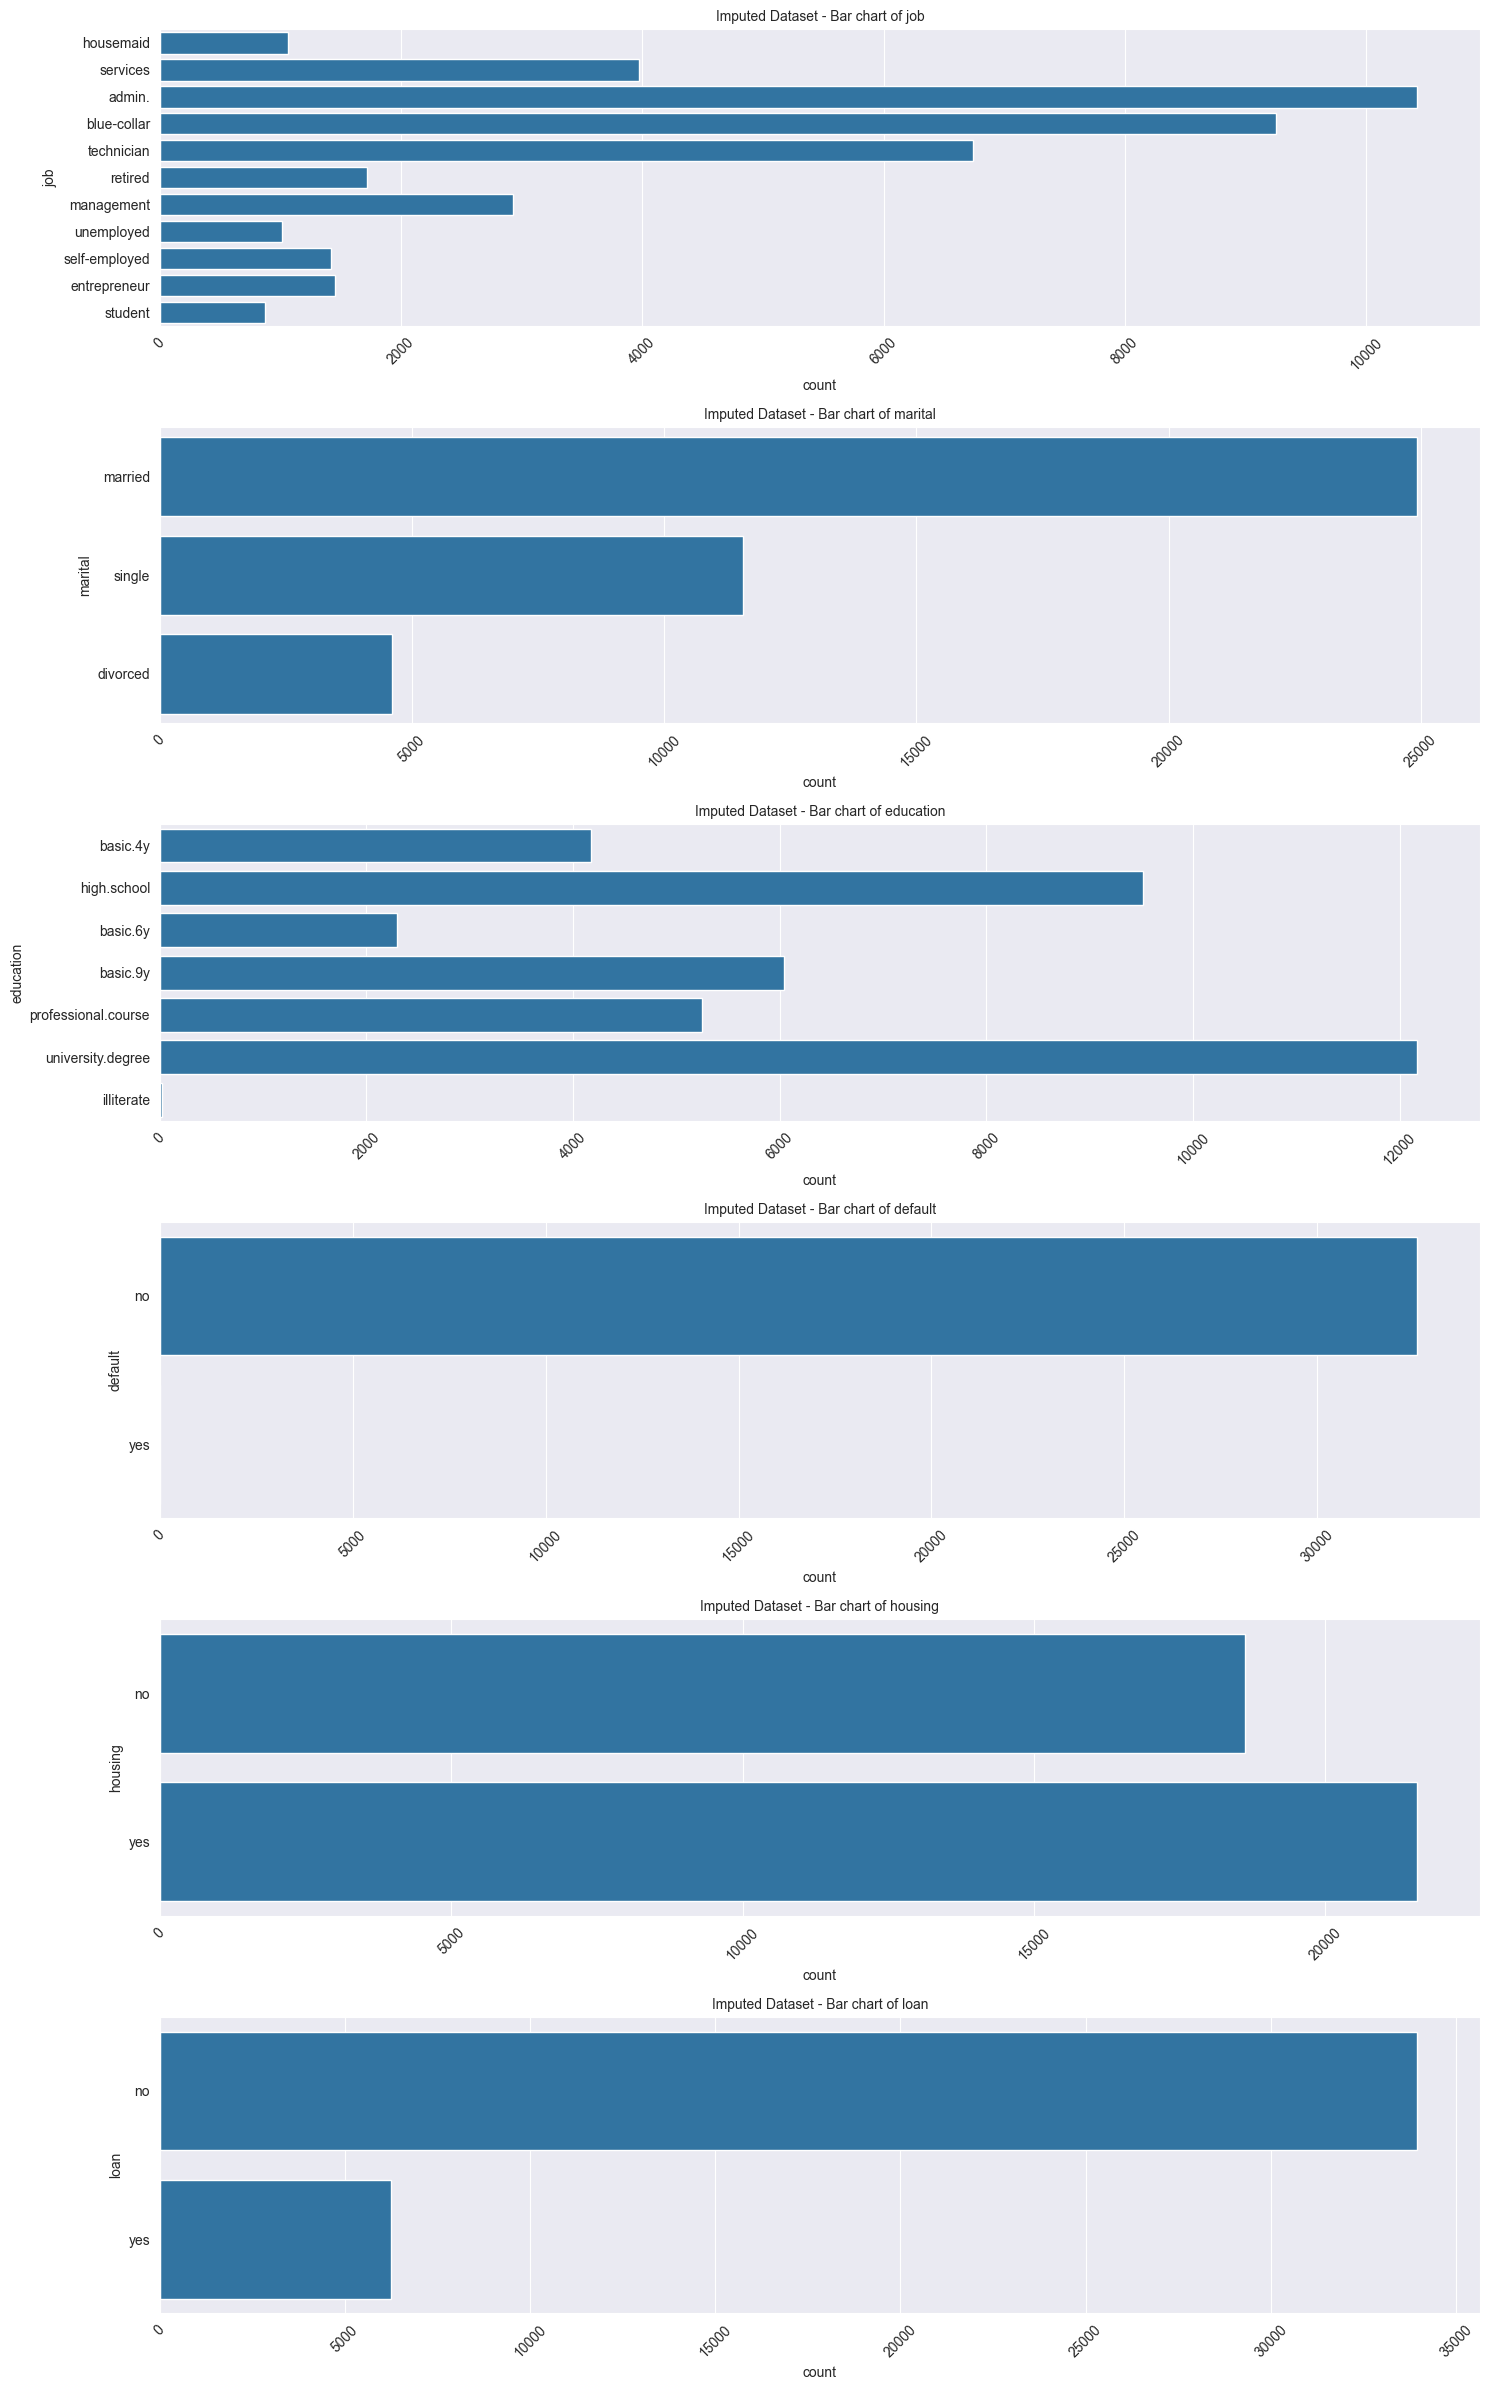

In [20]:
fig, axs = plt.subplots(len(unknown_val_feats), figsize=(15, 4*len(unknown_val_feats)))  # Adjust the size as necessary

# This code loops through your categorical features listed in unknown_val_feats
# and creates a bar chart for each on a separate subplot. 
for i, col_val in enumerate(unknown_val_feats):
    sns.countplot(df_filled[col_val], ax=axs[i])
    axs[i].set_title('Imputed Dataset - Bar chart of ' + str(col_val), fontsize=10)
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)  # Rotates X-axis labels for readability

plt.tight_layout()
plt.show()

**A point to consider:**
K-Nearest Neighbors (KNN) Imputer applies a distance-based imputation method, attempting to estimate missing values by looking at the "nearness" of records in the feature space. For categorical variables, this "nearness" or "distance" concept becomes ambiguous and less meaningful. The encoding of categories as ordinal numbers (as is required for KNN) also introduces an artificial ordering or relation between the categories, which might not genuinely exist. Furthermore, the categorical nature of the data disrupts the Euclidean or Manhattan distances usually used in KNN, leading to biased and potentially misleading results. Thus, KNN imputation is not recommended for categorical data without substantial justification or understanding of its implications.


In other words, I will continue with the initial dataset without using KNNImputer().

**Lastly I should map the target variable. The 'yes' value is mapped to 1 and 'no' is mapped to 0. Also note that I have imbalanced classes.**

[0 1]


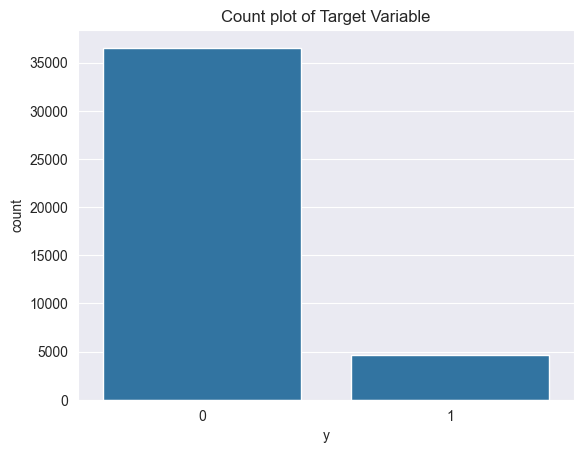

In [21]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})
print(df['y'].unique())


fig, ax = plt.subplots()
sns.countplot(x='y', data=df, ax=ax)
plt.title("Count plot of Target Variable")
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective:

**To develop a predictive model that can help the bank identify potential customers who are likely to subscribe to a term deposit. Such a model can help the bank focus its marketing efforts more efficiently, targeting those customers that are most likely to respond positively.**

Given this business objective, I may want to prioritize Precision and also consider Recall. Here's why:

- **Precision**: This measure gives me the proportion of true positives (potential customers who were correctly identified as likely to subscribe) out of the total predicted positives. A high precision indicates lower false positive rate i.e., the model's positive predictions are reliable, so the bank will waste less time and resources marketing to people who are unlikely to subscribe.

- **Recall** (Sensitivity): I might also consider this measure, especially if it's important for the bank not to miss out on potential subscriptions. Recall measures the proportion of actual positives (all potential customers who would subscribe) that were identified correctly. A higher Recall indicates fewer missed opportunities for new term deposits.

These two metrics usually have a trade-off, so depending on the bank's marketing strategy and capacity, I might want to balance between them. For instance, if the bank has a limited marketing budget and wants to be very precision-targeted, Precision will be more significant. But, if they fear to miss out potential customers and can afford to take some risks in targeting, higher Recall will be beneficial.

Note: If the bank wants to balance these two, then I could use the **F1 Score** (the harmonic mean of Precision and Recall) that gives equal weight to both Precision and Recall.

Moreover, I should consider using the **Area Under the Receiver Operating Characteristic Curve (AUC-ROC)**, as it provides a good measure of separability of classes and is robust against imbalanced data.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [22]:
# Get the names of the first seven columns
first_seven_cols = df.columns[:7].tolist()
# Add the target variable to the list of columns
selected_cols = first_seven_cols + ['y']

# Create the new dataframe
df_new = df[selected_cols]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        41188 non-null  int64 
 1   job        41188 non-null  object
 2   marital    41188 non-null  object
 3   education  41188 non-null  object
 4   default    41188 non-null  object
 5   housing    41188 non-null  object
 6   loan       41188 non-null  object
 7   y          41188 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 2.5+ MB


In [23]:
def create_preprocessor(encoding_type, categorical_features, numerical_features):
    """
    Create a column transformer for preprocessing the DataFrame.
    encoding_type: 'label', 'ordinal' or 'onehot'
    categorical_features: list of categorical feature names
    numerical_features: list of numerical feature names
    """

    # Choose the encoder based on encoding_type
    if encoding_type == 'onehot':
        encoder = OneHotEncoder(drop='first')
    elif encoding_type == 'ordinal':
        encoder = OrdinalEncoder()
    else:
        raise ValueError(f"Invalid encoding_type: {encoding_type}")

    # Set up the column transformer with appropriate transformers for each type of column
    preprocessor = make_column_transformer(
        (encoder, categorical_features),
        (StandardScaler(), numerical_features),
        remainder='passthrough'  # By default, unhandled columns will be passed through as is
    )

    return preprocessor

In [24]:
for encoder in ['onehot','ordinal']:
        # Create variable name
        var_name = f'column_transformer_{encoder}'
        # Use built-in function globals() to create a new global variable
        globals()[var_name] = \
        create_preprocessor(encoding_type = encoder
                            ,categorical_features = df_new[first_seven_cols].select_dtypes(include = ['object']).columns.to_list() #selecting categorical variables
                            ,numerical_features = df_new[first_seven_cols].select_dtypes(include = ['int64','float64']).columns.to_list() #selecting numerical variables
                            )


Below the structures of the created Column Transformers are shown:

In [25]:
column_transformer_ordinal

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan']),
                                ('standardscaler', StandardScaler(), ['age'])])

In [26]:
column_transformer_onehot

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan']),
                                ('standardscaler', StandardScaler(), ['age'])])

An example using the one of the above column transformers (using Standard Scaler and One Hot Encoder): 

In [27]:
# fitting the column transformer to data
processor_OH = column_transformer_onehot.fit(df_new[first_seven_cols])
# transforming the data
transformed_data = processor_OH.transform(df_new[first_seven_cols])
# converting the transformed data to a DataFrame
df_transformed_OH = pd.DataFrame.sparse.from_spmatrix(transformed_data)
df_transformed_OH.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.533034
1,0,0,0,0,0,0,1.0,0,0,0,...,0,0,0,1.0,0,0,0,0,0,1.628993
2,0,0,0,0,0,0,1.0,0,0,0,...,0,0,0,0,0,0,1.0,0,0,-0.290186
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.002309
4,0,0,0,0,0,0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1.533034


Also, let's transform the data by using the Ordinal Encoder and Standard Scaler.

In [28]:
# fitting the column transformer to data
processor_Ord = column_transformer_ordinal.fit(df_new[first_seven_cols])
# transforming the data
transformed_data = processor_Ord.transform(df_new[first_seven_cols])
# converting the transformed data (numpy) to a DataFrame
df_transformed_Ord = \
pd.DataFrame(transformed_data, columns = processor_Ord.get_feature_names_out())

I should notice the dimensions of the datasets before training computationally expensive models.

In [29]:
print('Using Standard Scaler and One Hot Encoder I create a dataset of '+str(df_transformed_OH.shape[0])+' rows '+'and '+str(df_transformed_OH.shape[1])+' columns')
print('Using Standard Scaler and Ordinal Encoder I create a dataset of '+str(df_transformed_Ord.shape[0])+' rows '+'and '+str(df_transformed_Ord.shape[1])+' columns')

Using Standard Scaler and One Hot Encoder I create a dataset of 41188 rows and 28 columns
Using Standard Scaler and Ordinal Encoder I create a dataset of 41188 rows and 7 columns


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

Now, I will split the data to subsets (80% train and 20% test). I will also stratify my split.

In [30]:
# Define the target variable and the feature matrix
y = df_new['y']
X = df_new.drop('y', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Below I ensure that the training set and testing set have similar distributions of a category or maintain the same proportion of the category as in the original dataset. This is important when splitting up data for training and testing a model to ensure fairness of the results.

In [31]:
# Compute counts in original data
original_counts = y.value_counts()
print('Original data:\n', original_counts)

# Compute counts in training set
training_counts = y_train.value_counts()
print('\nTraining set:\n', training_counts)

# Compute counts in test set
test_counts = y_test.value_counts()
print('\nTest set:\n', test_counts)

Original data:
 y
0    36548
1     4640
Name: count, dtype: int64

Training set:
 y
0    29238
1     3712
Name: count, dtype: int64

Test set:
 y
0    7310
1     928
Name: count, dtype: int64


I am doing the same by calculating the proportions of the classes of the target variable.

In [32]:
# Compute proportions in original data
original_props = y.value_counts(normalize=True)
print('Original data:\n', original_props*100)

# Compute proportions in training set
training_props = y_train.value_counts(normalize=True)
print('\nTraining set:\n', training_props*100)

# Compute proportions in test set
test_props = y_test.value_counts(normalize=True)
print('\nTest set:\n', test_props*100)

Original data:
 y
0    88.734583
1    11.265417
Name: proportion, dtype: float64

Training set:
 y
0    88.734446
1    11.265554
Name: proportion, dtype: float64

Test set:
 y
0    88.73513
1    11.26487
Name: proportion, dtype: float64


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

A typical method for setting a baseline for classification tasks is to use a simple model and compare the performance of more complex models against it.

For binary classification, one common baseline method is the "Zero Rule" (ZeroR) or "Most Frequent" classifier. This classifier always predicts the most frequent class in the training dataset.

The code below calculates the maximum relative frequency of the unique values in the y_train data series, which can indicate the baseline accuracy of a model that always predicts the most common class.

In [33]:
baseline_accuracy = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {baseline_accuracy*100:.2f}%")

Baseline accuracy: 88.73%


So my classifiers should have at least an accuracy of 88.73%. Another approach is to use the Dummy Classifier:

In [34]:
# Initialize the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Fit the dummy classifier
dummy.fit(X_train, y_train)

# Use the dummy classifier to make predictions
dummy_preds = dummy.predict(X_test)

# Evaluate the baseline model
baseline_accuracy = accuracy_score(y_test, dummy_preds)

print(f"Baseline accuracy: {baseline_accuracy*100:.2f}%")

Baseline accuracy: 88.74%


Dummy Classifier results to the same accuracy.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

First I will create a function that will use simple models (default hyperparameter values of the classifiers) to construct some basic Pipelines.

In [35]:
def create_pipeline(transformer, estimator_name):
    if estimator_name == 'LogisticRegression':
        estimator = LogisticRegression(random_state=42)
    elif estimator_name == 'KNeighborsClassifier':
        estimator = KNeighborsClassifier()
    elif estimator_name == 'DecisionTreeClassifier':
        estimator = DecisionTreeClassifier(random_state=42)
    elif estimator_name == 'SVC':
        estimator = SVC(random_state=42,coef0=1, probability=True)
    else:
        raise ValueError(f"Invalid estimator_name: {estimator_name}")

    if transformer == 'onehot':
        transformer = column_transformer_onehot
    elif transformer == 'ordinal':
        transformer = column_transformer_ordinal
    else:
        raise ValueError(f"Invalid transformer: {transformer}")

    pipeline = Pipeline([
        ('preprocessor', transformer),
        ('estimator', estimator)
    ])

    return pipeline

For Logistic Regression, KNN classifier and Support Vectors Machine Classifier I will use the One Hot Encoder and Standard Scaler. For the Decision Trees classifier I will try Standard Scaler and One Hot Encoder. Furthermore, although Ordinal Encoder is used only to ordinal variables (it seems I use only nominal variables) I could also try it, in order **not** to increase the dimensions of the training dataset. 

In [36]:
# to calculate training time for the model: end_time - start_time
########################
start_t_LR = time.time() #start_time 
basic_LR = create_pipeline(transformer = 'onehot',
                           estimator_name = 'LogisticRegression'
                          ).fit(X_train,y_train)
end_t_LR = time.time() #end_time 

########################
start_t_KNN = time.time() #start_time
basic_KNN = create_pipeline(transformer = 'onehot',
                            estimator_name = 'KNeighborsClassifier'
                            ).fit(X_train,y_train)
end_t_KNN = time.time() #end_time


########################
start_t_SVM = time.time() #start_time
basic_SVM= create_pipeline(transformer = 'onehot',
                           estimator_name = 'SVC'
                          ).fit(X_train,y_train)
end_t_SVM = time.time() #end_time


########################
start_t_DT_ord = time.time() #start_time
basic_ordinal_DT= create_pipeline(transformer = 'ordinal',
                                  estimator_name = 'DecisionTreeClassifier'
                                 ).fit(X_train,y_train)
end_t_DT_ord = time.time() #end_time


########################
start_t_DT_ord = time.time() #start_time
basic_oh_DT= create_pipeline(transformer = 'onehot',
                             estimator_name = 'DecisionTreeClassifier'
                            ).fit(X_train,y_train)
end_t_DT_ord = time.time() #end_time

### Problem 9: Score the Model

What is the accuracy of your model?

In [37]:
print('The accuracy score of the basic Logistic Regression Model is: ' +str( np.round(accuracy_score(y_test,basic_LR.predict(X_test))*100, 3)) )

The accuracy score of the basic Logistic Regression Model is: 88.735


The accuracy score of the basic Logistic Regression is around the same with the accuracy of the Dummy Classifier. I have to improve the model, insert more variables or create more insightful features (feature engineering) to use in my modelling phase. I should also check the other models and metrics.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [38]:
# Initialize an empty dictionary to store metrics
metrics = {}

models = [('basic_LR', basic_LR, end_t_LR - start_t_LR),
          ('basic_KNN', basic_KNN, end_t_KNN - start_t_KNN),
          ('basic_SVM', basic_SVM, end_t_SVM - start_t_SVM),
          ('basic_ordinal_DT', basic_ordinal_DT, end_t_DT_ord - start_t_DT_ord),
          ('basic_oh_DT', basic_oh_DT, end_t_DT_ord - start_t_DT_ord)]

for model_name, model, training_time in models:
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred, zero_division=0)
    precision = precision_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)

    # Store metrics in the dictionary
    metrics[model_name] = {
        'training_time': training_time,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1
    }

Below, all the metrics for the simple Logistic Regression are printed:

In [39]:
print(metrics['basic_LR'])

{'training_time': 0.17699313163757324, 'train_accuracy': 0.8873444613050075, 'test_accuracy': 0.8873512988589464, 'recall': 0.0, 'precision': 0.0, 'f1_score': 0.0}


Notice the precision, recall and f1 scores (zeros) of Logistic Regression. This insight shows that the predictions for the positive class during testing had no True Positives, resulting in a precision of 0/0 which is undefined (parameter zero_division=0). This can occur commonly with imbalanced datasets, where the model might predict the majority class for all instances.

Creating a report of models' metrics below:

In [40]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics

,training_time,train_accuracy,test_accuracy,recall,precision,f1_score
basic_LR,0.176993,0.887344,0.887351,0.000000,0.000000,0.000000
basic_KNN,0.090044,0.891381,0.881039,0.073276,0.361702,0.121864
basic_SVM,370.833346,0.888255,0.886502,0.008621,0.347826,0.016824
basic_ordinal_DT,0.662408,0.917056,0.865987,0.095905,0.251412,0.138846
basic_oh_DT,0.662408,0.917056,0.863559,0.084052,0.221591,0.121875


 The df_metrics is a DataFrame where rows (indices) correspond to model names, and columns correspond to different metrics like training time, test accuracy, etc.

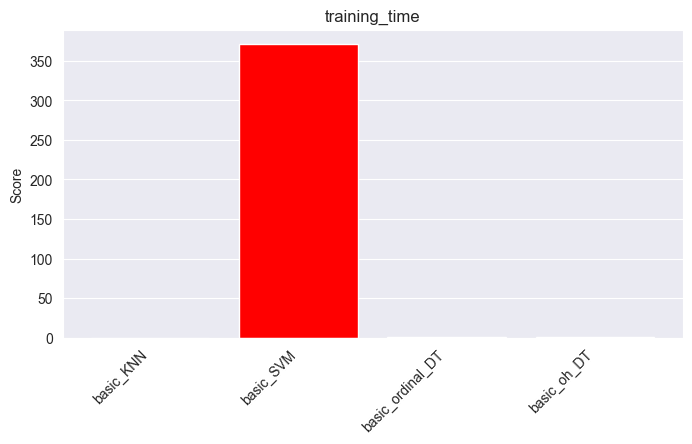

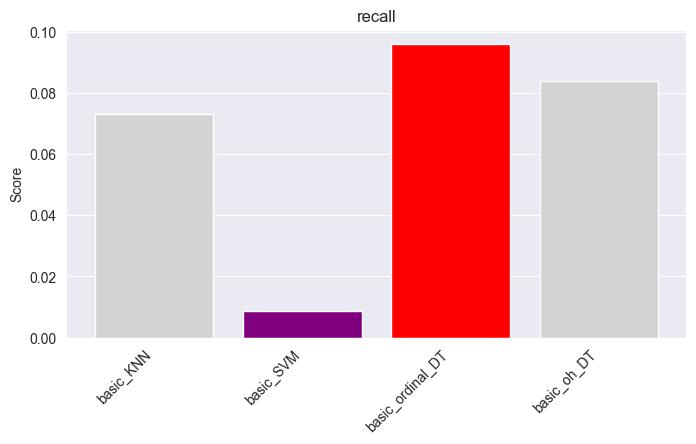

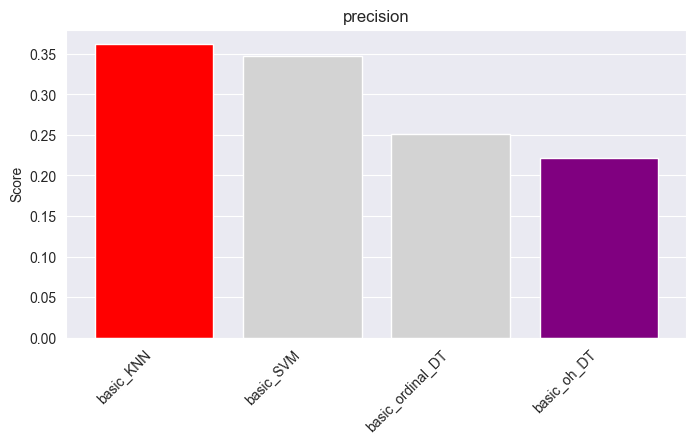

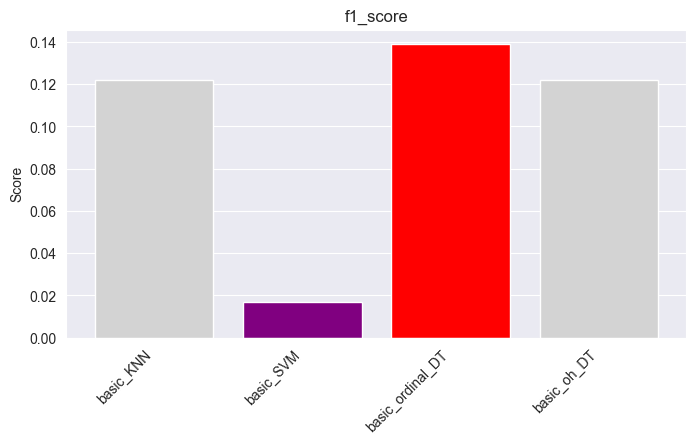

In [41]:
# Dataframe without accuracy scores
# Also I do not use the first row of the dataframe (Logistic Regression) as it has zero devision Precision, Recall and f1 score.
df_metrics_no_LR = df_metrics[1:].drop(columns=['train_accuracy', 'test_accuracy'])

for column in df_metrics_no_LR.columns:
    plt.figure(figsize=(8, 4))

    max_val = df_metrics_no_LR[column].max() #find the max value in column
    min_val = df_metrics_no_LR[column].min() #find the min value in column

    # Loop through each bar (model name)
    for i, model in enumerate(df_metrics_no_LR.index):
        # assign colors to max, min and other values
        color = 'red' if df_metrics_no_LR[column][model] == max_val else 'purple' if df_metrics_no_LR[column][model] == min_val else 'lightgrey'
        # Plot a single bar
        plt.bar(model, df_metrics_no_LR[column][model], color=color)

    plt.title(column)
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='x')

    plt.show()

As a general guideline, an F1 score of 0.7 or higher is often considered good. As shown above all scores are bad. I should consider a different approach or to fine-tune the models' hyperparameters through grid search algorithm. The decision tree classifier with the ordinal encoder seems to behave better (f1 score and recall) than the other models. Also, KNN seems quite promising, when considering the f1 score and precision.

Below I create a function that plots ROC curves for the given models. Also, it returns the AUC scores as a dictionary.

In [42]:
def plot_roc_curves(models, X_test, y_test, model_names=None):
    """
    This function plots ROC curves for the given models.
    Parameters:
        models: A list of trained sklearn models.
        X_test: The test set features.
        y_test: The test set targets.
        model_names: (optional) A list of names of the models.
    Returns:
        A dictionary of ROC AUC scores for the models.
    """
    # Initialize dictionary for AUC scores
    auc_scores = {}
    sns.set(style="darkgrid", palette="bright")
    # Initialize the figure
    plt.figure(figsize=(10,6))
    
    # Your existing code...
    for model, name in zip(models, model_names):
        # Get the model's prediction probabilities
        y_score = model.predict_proba(X_test)[:,1]
    
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score)
    
        # Calculate the AUC score
        auc_score = roc_auc_score(y_test, y_score)
        auc_scores[name] = auc_score
    
        # Plot the ROC curve directly using plt.plot for every given model
        plt.plot(fpr, tpr, label=f'{name}, AUC={auc_score:.2f}')
      
    #
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
    plt.title('ROC curve')
    # Place the legend outside the figure/plot
    plt.legend(title='Model',bbox_to_anchor=(1, 1) )
    plt.grid(True)
    plt.tight_layout()
    return auc_scores

Applying the function below:

{'basic_LR': 0.6493029594556347,
 'basic_KNN': 0.5925304554460116,
 'basic_SVM': 0.5806539370960895,
 'basic_ordinal_DT': 0.5823113708193783,
 'basic_oh_DT': 0.5723972828907025}

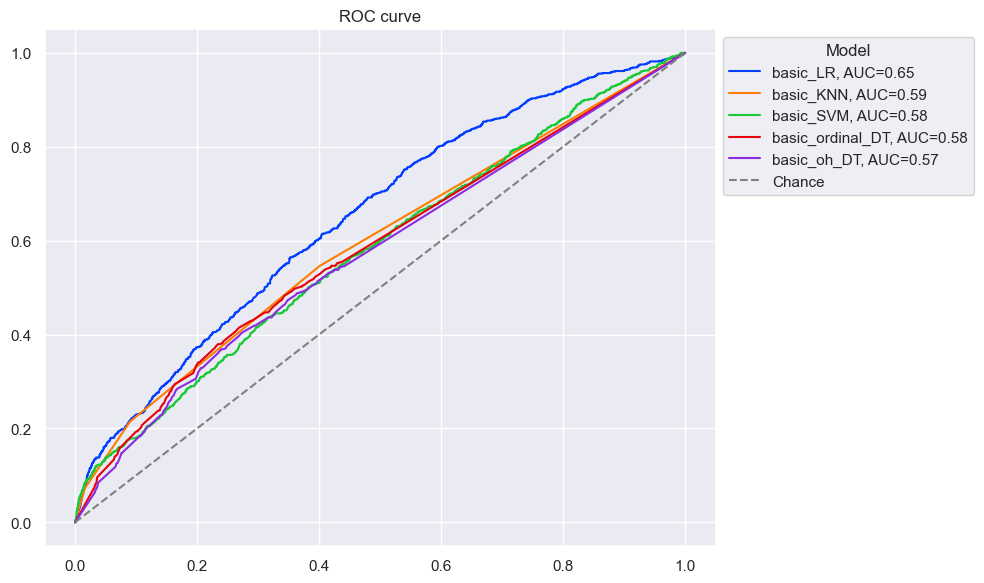

In [43]:
# List of models and their names
models = [basic_LR, basic_KNN, basic_SVM, basic_ordinal_DT, basic_oh_DT]
model_names = ['basic_LR', 'basic_KNN', 'basic_SVM', 'basic_ordinal_DT', 'basic_oh_DT']

plot_roc_curves(models = models
                ,X_test = X_test
                ,y_test = y_test
                ,model_names = model_names
                )

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Based on the above results the models need improvement. In order to improve the models I will follow the strategy below:
- First I will add more features. I will use PCA on features emp.var.rate , cons.price.idx, euribor3m, nr.employed to reduce them to 1 or 2 columns. In addition I will add poutcome to my pipelines.

In [46]:
def plot_feature_distribution(df, feature, target):
    """
    Plot the distribution of a feature variable in a dataframe for different target variable values.

    :param df: The dataframe containing the data.
    :param feature: The feature variable to plot the distribution of.
    :param target: The target variable used to group and differentiate the distributions.

    :return: None
    """
    subsets = df[target].unique()

    plt.figure(figsize=(10,8))

    for subset in subsets:
        sns.histplot(df[df[target] == subset][feature], kde=True, label=subset)

    plt.legend(prop={'size': 12})
    plt.title('Feature Distribution for different Target Variable Values')
    plt.xlabel(feature)
    plt.ylabel('Density')

    plt.show()

In [98]:
(df['y'].groupby(df['month']).value_counts(normalize=True).rename('proportion').reset_index())

,month,y,proportion
0,apr,0,0.795213
1,apr,1,0.204787
2,aug,0,0.893979
3,aug,1,0.106021
4,dec,0,0.510989
5,dec,1,0.489011
6,jul,0,0.909534
7,jul,1,0.090466
8,jun,0,0.894885
9,jun,1,0.105115


In [112]:
def plot_feature_distribution(df, feature, target, visualisation_size_numeric = (12,5), visualisation_size_categ = (9,5)):

    # suppress all warnings
    warnings.filterwarnings('ignore')
    
    
    subsets = df[target].unique()

    if df[feature].dtype == 'object':
        # If the feature is a categorical
        fig, ax =plt.subplots(nrows=1, ncols=2, figsize= visualisation_size_categ)
    
        prop_df=(df[target]
                 .groupby(df[feature])
                 .value_counts(normalize=True)
                 .rename('proportion')
                 .reset_index())
    
        sns.barplot(x=feature, y='proportion', hue=target, data=prop_df, ax=ax[0])
        sns.pointplot(x=feature, y='proportion', hue=target, data=prop_df, ax=ax[1])
    
        ax[0].set_title('Proportional distribution plot for ' + feature)
        ax[1].set_title('Point distribution plot for ' + feature)
    
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.tight_layout()
    
    else:

        fig, ax =plt.subplots(nrows=1, ncols=2, figsize= visualisation_size_numeric)
        for subset in subsets:
            sns.histplot(df[df[target] == subset][feature], kde=True, label=subset, ax=ax[0])
    
        sns.violinplot(x=target, y=feature, data=df, inner='quartile',hue = target, split = True, width = 0.95, ax=ax[1])
    
        ax[0].set_title(feature+' distribution for different target classes')
        ax[0].set_ylabel('Density')
        ax[0].legend(prop={'size': 12})
    
        ax[1].set_title('Violin plot of '+feature+' per target class')
    
        plt.tight_layout()
        plt.show()

Add contact, poutcome, default,
month, day_of_week --> encode them as ordinals

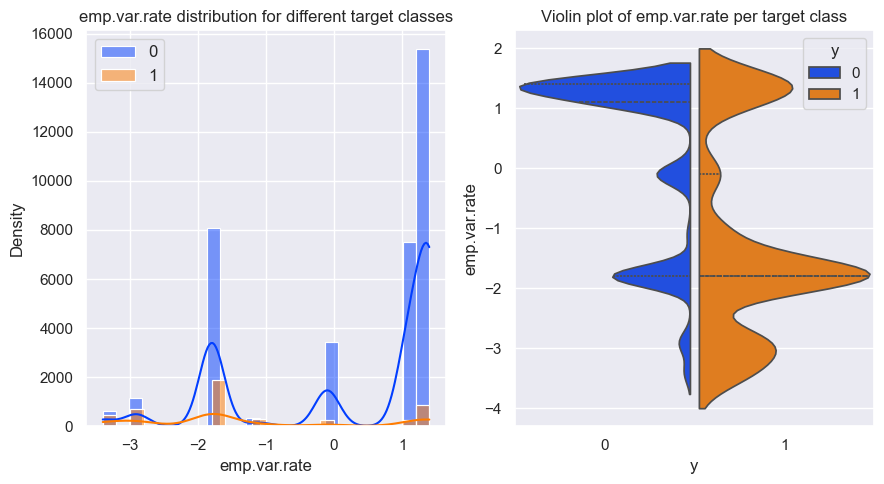

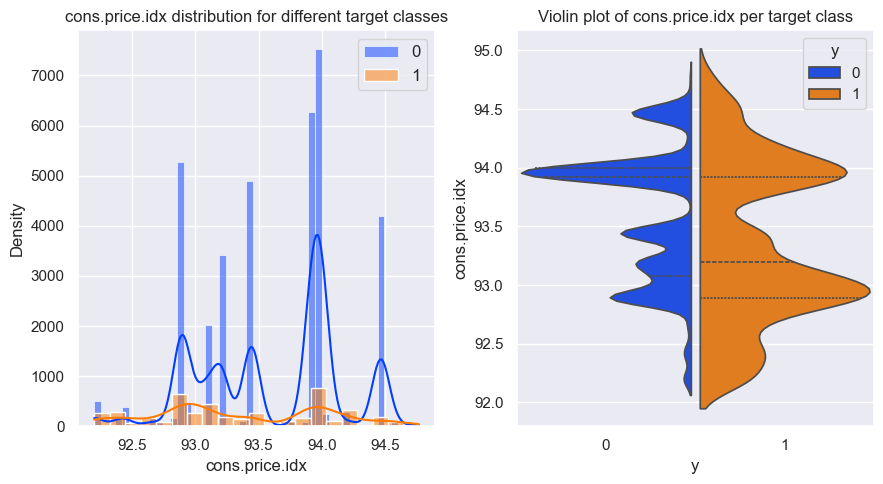

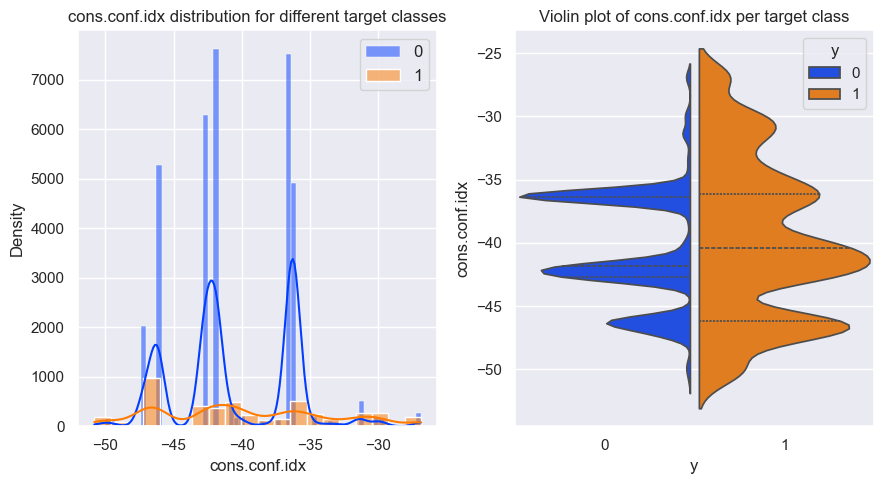

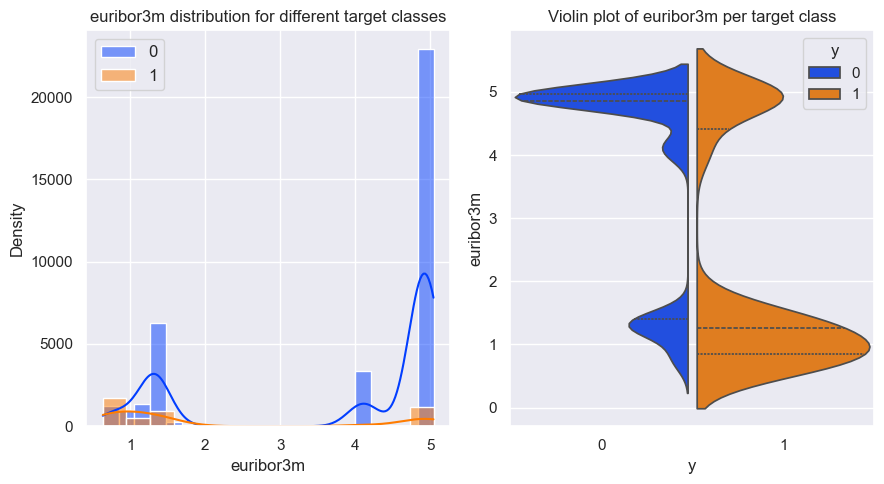

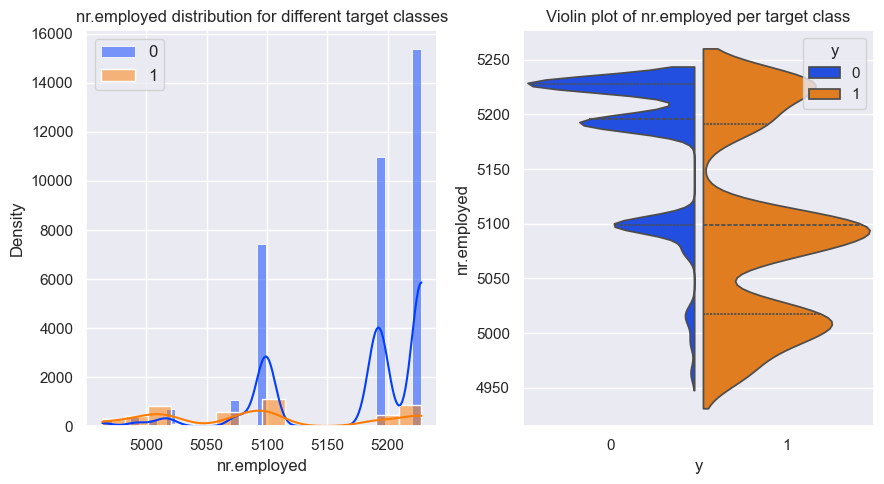

In [116]:
columns_to_plot = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
for i in columns_to_plot:
    plot_feature_distribution(df = df, feature = i, target = 'y', visualisation_size_numeric = (9, 5))

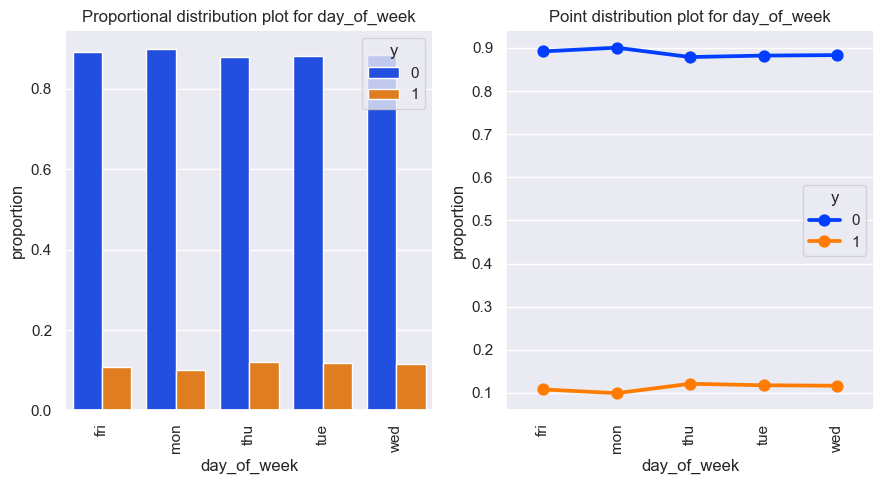

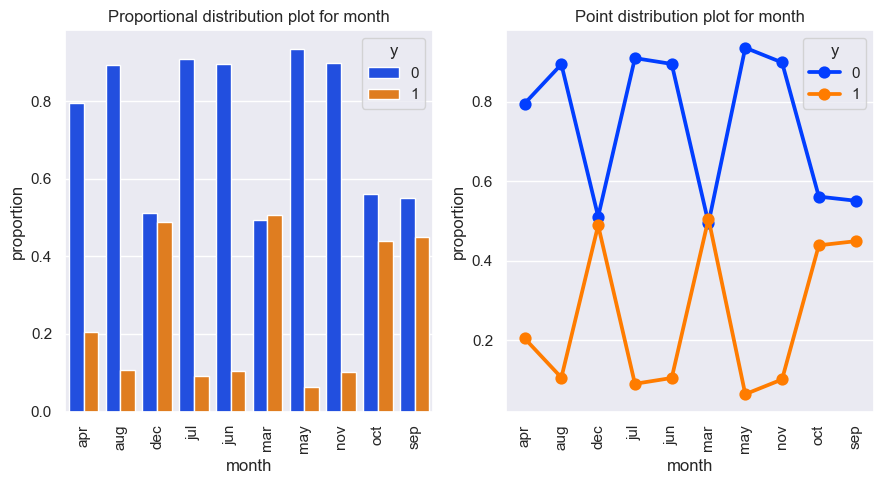

In [117]:
columns_to_plot = ['day_of_week', 'month']
for i in columns_to_plot:
    plot_feature_distribution(df = df, feature = i, target = 'y', visualisation_size_numeric = (12, 5))

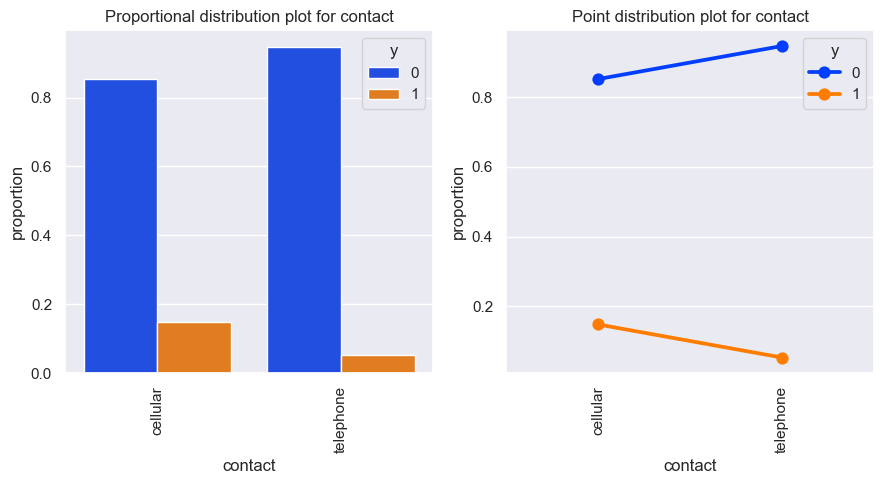

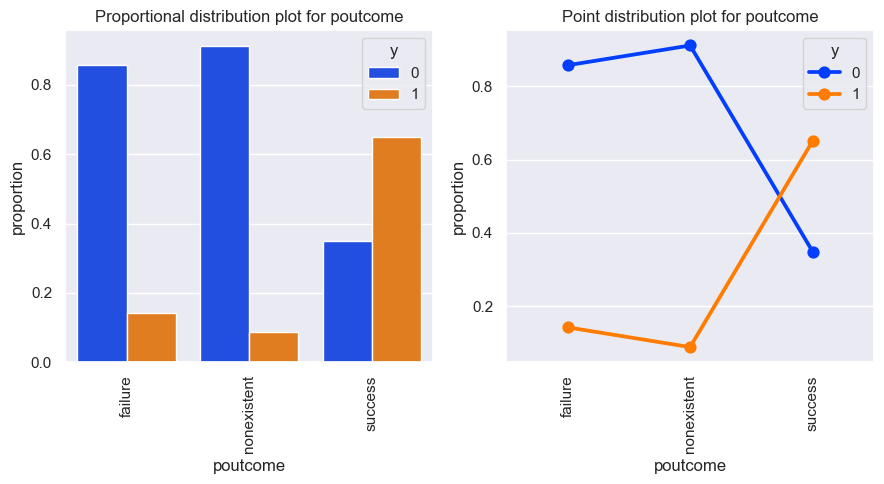

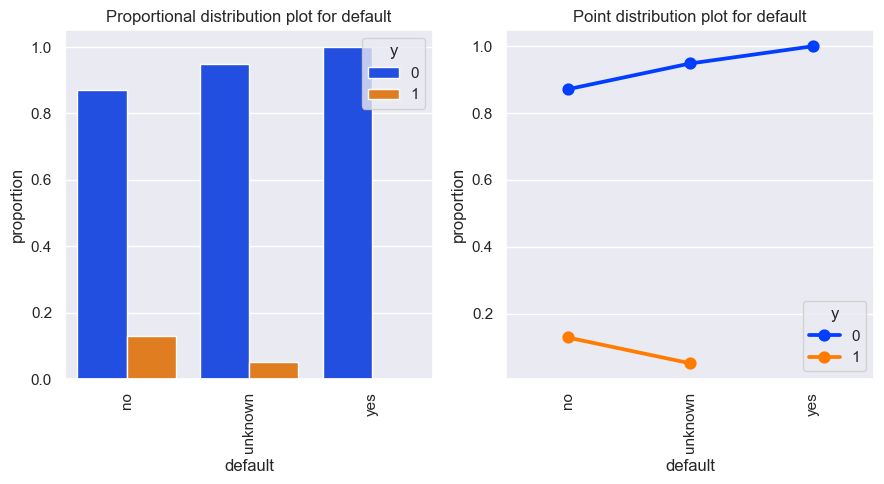

In [115]:
columns_to_plot = ['contact', 'poutcome', 'default']
for i in columns_to_plot:
    plot_feature_distribution(df = df, feature = i, target = 'y', visualisation_size_numeric = (12, 5))

In [44]:
df.query('y==1')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contacted_before
75,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1,no
83,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1,no
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1,no
129,41,technician,married,professional.course,unknown,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1,no
139,45,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41174,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,1,6,success,-1.1,94.767,-50.8,1.031,4963.6,1,yes
41178,62,retired,married,university.degree,no,no,no,cellular,nov,thu,...,2,3,success,-1.1,94.767,-50.8,1.031,4963.6,1,yes
41181,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,...,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,no
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,no


In [45]:
df.query('y==0')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contacted_before
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41180,36,admin.,married,university.degree,no,no,no,cellular,nov,fri,...,2,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,no
41182,29,unemployed,single,basic.4y,no,yes,no,cellular,nov,fri,...,1,1,success,-1.1,94.767,-50.8,1.028,4963.6,0,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,no
